In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[How Machine Learning Is Propelling Structural Biology.](https://hms.harvard.edu/news/how-machine-learning-propelling-structural-biology)

___

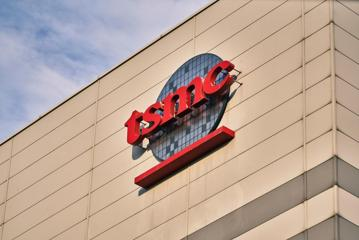

[TSMC beats, raises, stock drops.](https://finance.yahoo.com/news/tsmc-profit-surpasses-estimates-ai-053450831.html) - Yahoo Finance

___

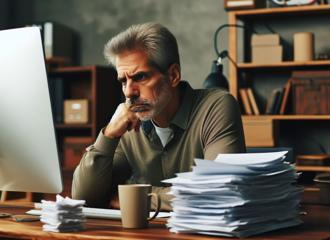

[Microsoft adds gen AI to desktop suite, as part of a Copilot subscription.](https://www.pcworld.com/article/2403020/microsoft-wants-you-to-pay-300-per-year-for-ai-art-in-word.html) - PCWorld

___

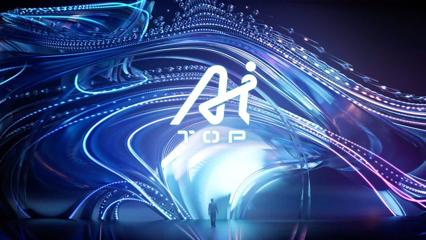

[You can also fine-tune this models on your own tasks, tooling is evolving rapidly.](https://www.tomshardware.com/tech-industry/artificial-intelligence/gigabyte-releases-ai-software-to-help-train-your-own-ai) - Tom's Hardware

___

name 'httplib' is not defined


[Nvidia and Mistral release 12b-parameter open source model with a 128k-context window that you can run on your desktop. Sounds like it might give Gemma 22b a run for its money and maybe I can run a quantized versin on my current 24GB MacBook Air?](https://mistral.ai/news/mistral-nemo/?ref=upstract.com)

___

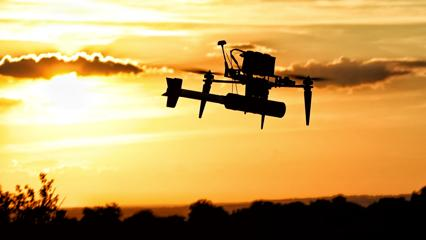

[Ukraine sends drone swarms against Russians.](https://www.pcmag.com/news/ukraine-building-ai-war-drone-fleet-to-combat-russian-forces) - PCMAG

___

[Meta suspends gen-AI tools in Brazil over privacy and training issues.](https://www.reuters.com/technology/artificial-intelligence/meta-decides-suspend-its-generative-ai-tools-brazil-2024-07-17/)

___

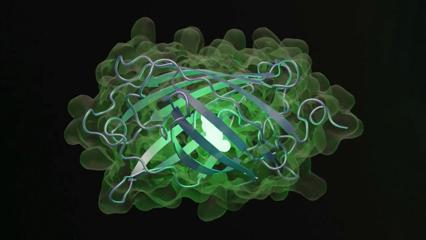

[Ex-Meta scientists develop AI that creates novel proteins not seen in nature. Sounds like the start of a horror movie.](https://www.livescience.com/technology/artificial-intelligence/chatgpt-moment-for-biology-ex-meta-scientists-develop-ai-that-creates-proteins-not-found-in-nature) - livescience.com

___

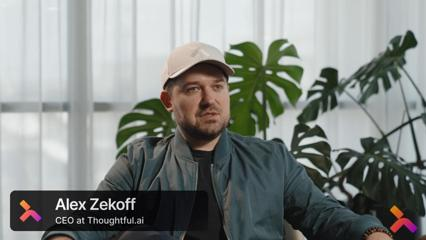

[Startup raises \\$20m for AI agents to help healthcare providers with billing and back office tasks.](https://finance.yahoo.com/news/thoughtful-ai-launches-human-capable-120500411.html) - Yahoo Finance

___

[In China, you can get a high spec AI-capable phone for \\$140.](https://www.gizmochina.com/2024/07/16/meizu-blue-20-ai-phone-annnounced/)

___

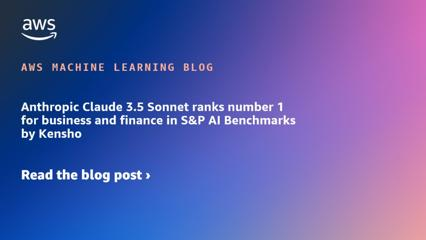

[A lot of people like Claude Sonnet better than ChatGPT for their use case but practically, not much separates them. I saw a Claude display on the giant billboard in Penn Station the other day, OpenAI still gets all the recognition.](https://aws.amazon.com/blogs/machine-learning/anthropic-claude-3-5-sonnet-ranks-number-1-for-business-and-finance-in-sp-ai-benchmarks-by-kensho/) - Amazon Web Services

___

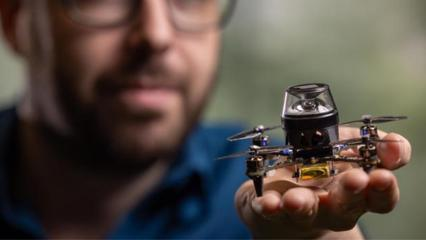

[56g drone could monitor indoor warehouses, air quality, what you are doing at your desk.](https://interestingengineering.com/innovation/insect-inspired-navigation-robot) - Interesting Engineering

___

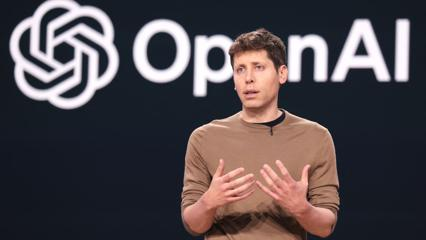

[OpenAI is releasing a small model. Not seeing the details yet or, the question is how much cheaper and faster it is vs. GPT-4o, and how it compares. If you want quick cheap non-frontier responses, right now you can use GPT-3.5 (or competitors/local models), presumably this will be an improvement.](https://www.cnbc.com/2024/07/18/openai-4o-mini-model-announced.html) - CNBC

___

[Rabbit R1 has some issues with potentially leaking your data if you lose it, and some IP issues.](https://www.da.vidbuchanan.co.uk/blog/r1-jailbreak.html)

___

[Mistral releases small, capable models for code generation and math.](https://venturebeat.com/ai/mistral-releases-codestral-mamba-for-faster-longer-code-generation/) - VentureBeat

___

[Meta will not release future AI models in Europe over the issue of training on user data.](https://www.axios.com/2024/07/17/meta-future-multimodal-ai-models-eu)

___

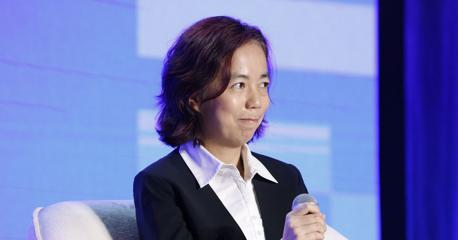

[Dr Fei-Fei raises for spatial computing at \\$1b valuation.](https://www.theverge.com/2024/7/17/24200496/ai-fei-fei-li-world-labs-andreessen-horowitz-radical-ventures) - The Verge

___

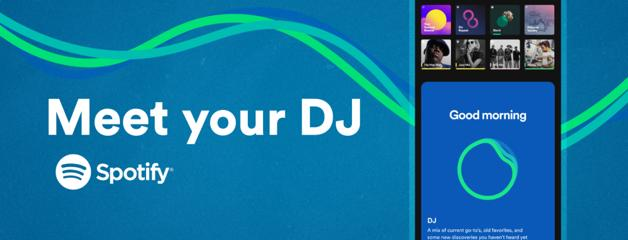

[Spotify releases Spanish version of its AI DJ.](https://www.engadget.com/spotifys-ai-music-dj-can-now-speak-spanish-180022156.html) - Engadget

___

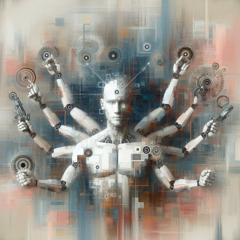

[AIXplain raises \\$6.5m for low-code AI agent dev platform.](https://siliconangle.com/2024/07/17/aixplain-nabs-6-5m-simplify-ai-agent-development/) - SiliconANGLE

___

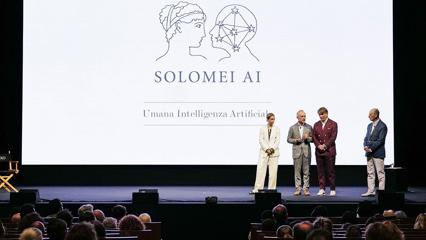

[Italian fashion brand Brunello Cucinelli unveils AI-driven website.](https://www.voguebusiness.com/story/technology/why-brunello-cucinelli-believes-ai-is-the-future) - Vogue Business

___

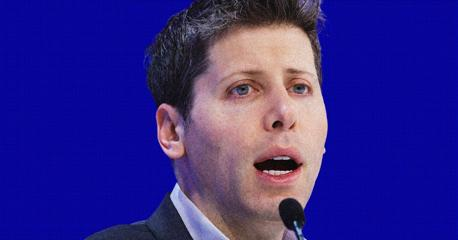

[OpenAI Touts New AI Safety Research. Critics Say It’s a Good Step, but Not Enough](https://www.wired.com/story/openai-safety-transparency-research/) - WIRED

___

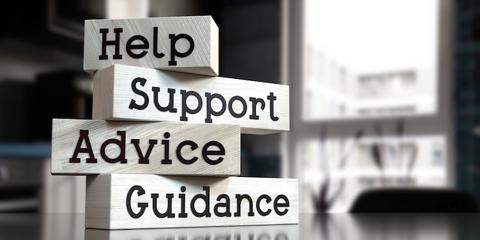

[USPTO updates guidance on AI inventions.](https://ipwatchdog.com/2024/07/16/uspto-updates-eligibility-guidance-ai-want-accelerate-ai-innovation-without-locking/id=178900/) - IPWatchdog.com | Patents & Intellectual Property Law

___

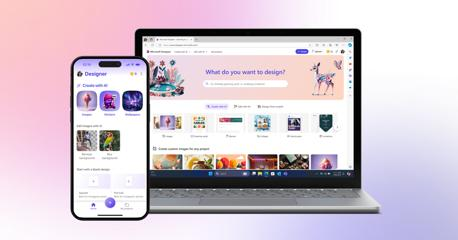

[Microsoft Designer app brings Canva-like functionality.](https://www.theverge.com/2024/7/17/24200294/microsoft-designer-app-launch-windows-ios-android-features) - The Verge

___

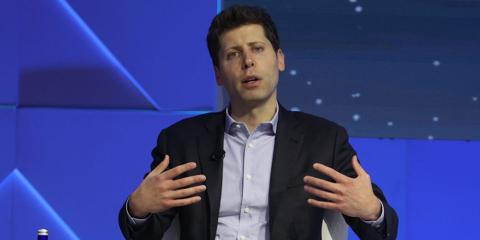

[If you talk to an AI doctor or psychiatrist or lawyer or spiritual adviser or personal assistant, should those conversations be privileged?](https://www.businessinsider.com/sam-altman-ai-privilege-health-data-safeguards-regulation-2024-7) - Business Insider

___

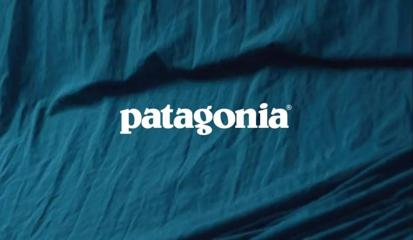

[Unresolved disclosure, privacy, explainability, fairness issues impact customer service chatbot adoption](https://therecord.media/patagonia-sued-privacy-invasion-california)

___

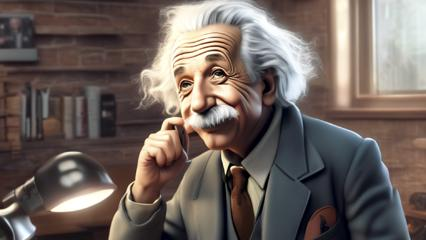

[Salesforce ships a customer-facing AI chatbot](https://venturebeat.com/ai/salesforce-debuts-einstein-service-agent-a-new-ai-agent-for-customer-self-service/) - VentureBeat

___

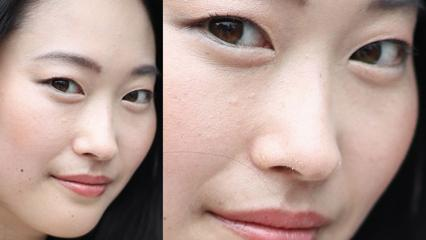

[Canon cameras will have in-camera NPUs and enhance your pictures as you take them. Extra fingers free of charge!](https://www.digitalcameraworld.com/features/oh-my-god-canons-in-camera-ai-is-going-to-change-everything) - digitalcameraworld

___

/opt/anaconda3/envs/ainewsbot/lib/python3.9/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


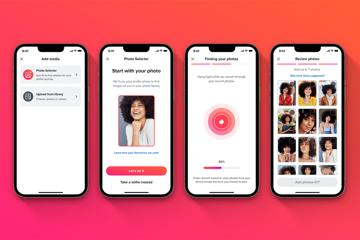

[Tinder AI will go through your photos and post the best pictures on your profile. Why stop there, just write the profile?](https://techcrunch.com/2024/07/17/tinder-ai-photo-selection-feature-launches/?guccounter=1) - TechCrunch

___

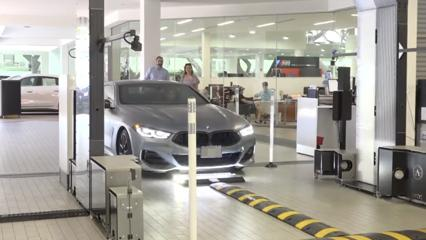

[MRI for cars does robotic fully autonomous inspections.](https://www.the-sun.com/motors/11940028/ai-visual-car-inspection-bmw-hawaii/) - The US Sun

___

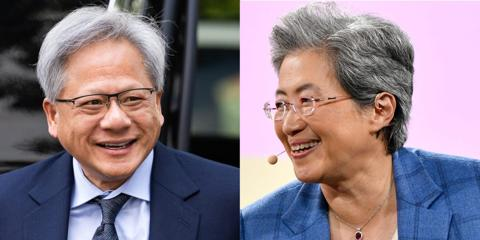

[AMD's AI head talks about how they are catching up to Nvidia with open-source CUDA and software stack alternatives.](https://www.businessinsider.com/amd-ai-vp-gpu-shortage-nvidia-lock-in-2024-7) - Business Insider

___

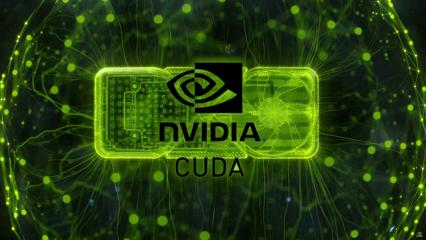

[Toolkit allows CUDA to run on AMD using LLVM cross-compilation.](https://wccftech.com/nvidia-cuda-directly-run-on-amd-gpus-using-scale-toolkit/) - Wccftech

___

[A prompt that makes ChatGPT text more human-like.](https://www.twixify.com/post/how-to-make-chatgpt-undetectable)

___

[AI creates a fashion show](https://www.reddit.com/r/ChatGPT/comments/1e5axi9/ai_fashion_lingerie_show/)

___

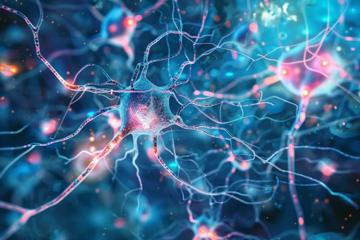

[AI identifies 3 Parkinsons's subtypes.](https://neurosciencenews.com/ai-parkinsons-subtypes-26451/) - Neuroscience News

___

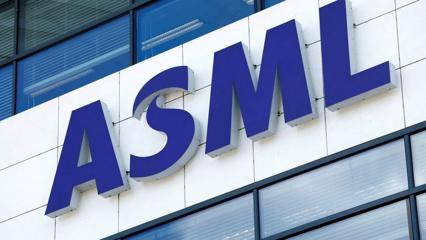

[ASML beats forecasts, bookings surge for its 9-figure chip fabrication kit.](https://www.cnbc.com/2024/07/17/asml-earnings-report-q2-2024.html) - CNBC

___

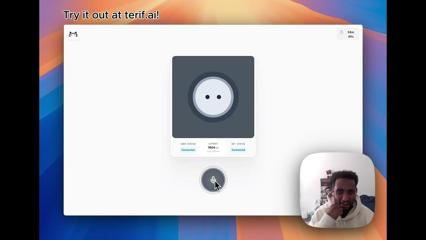

[Watch a bot learn to speak like you in a couple of minutes.](https://www.youtube.com/watch?v=xIv4Cp8tePI) - YouTube

___

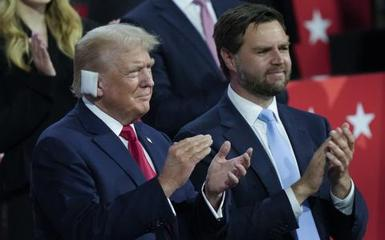

[Trump's Silicon Valley allies draft AI 'Manhattan project' for defense. JD Vance (fka Bowman) is a Peter Thiel creation, and that PayPal Mafia, Musk, Sacks, a16z have gone all-in on Trump.](https://www.stripes.com/theaters/us/2024-07-16/trump-allies-draft-ai-order-manhattan-projects-14506387.html) - Stars and Stripes

___

[Yandex founder splits with 1,300 engineers, starts AI venture in Holland and Finland.](https://www.reuters.com/markets/deals/former-yandex-chief-volozh-returns-with-ai-infrastructure-venture-after-russia-2024-07-16/)

___

[FTC probing Amazon hire of AI startup Adept's staff.](https://www.reuters.com/technology/ftc-seeking-details-amazon-deal-with-ai-startup-adept-source-says-2024-07-16/)

___

[Karpathy is building an AI education company, yay eurekalabs.ai](https://eurekalabs.ai/)

___

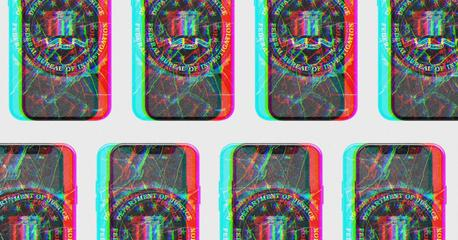

[not really in evidence since we don't know how it was protected, they had his face and thumb, someone else could have had the password](https://www.theverge.com/24199357/fbi-trump-rally-shooter-phone-thomas-matthew-crooks-quantico-mdtf) - The Verge

___

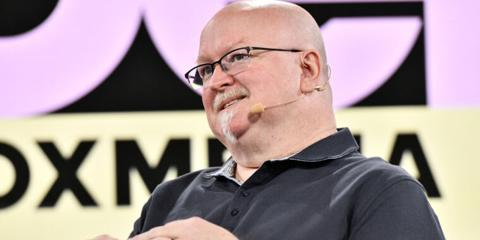

[Microsoft CTO sees no diminishing returns to scale yet in LLMs.](https://arstechnica.com/information-technology/2024/07/microsoft-cto-defies-critics-ai-progress-not-slowing-down-its-just-warming-up/) - Ars Technica

___

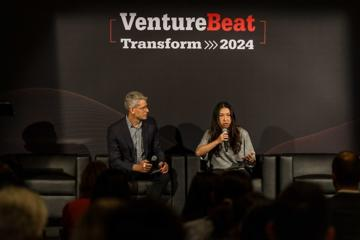

[How Intuit is personalizing finance with AI. (personalized ass-rape as a service?)](https://venturebeat.com/ai/top-ten-ways-intuit-is-revolutionizing-personalization-with-generative-ai/) - VentureBeat

___

[Your port or insurance company can use AI to evaluate how sketchy that ship is that's using your facility.](https://splash247.com/artificial-intelligence-from-amazon-deployed-in-maritime/)

___

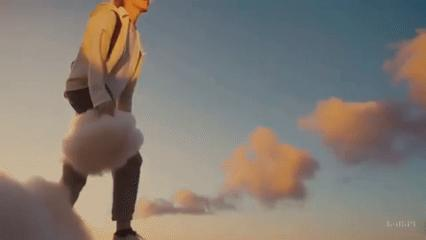

[2 new Sora videos from OpenAI](https://www.tomsguide.com/ai/ai-image-video/openai-just-dropped-2-new-sora-videos-and-they-look-very-impressive) - Tom's Guide

___

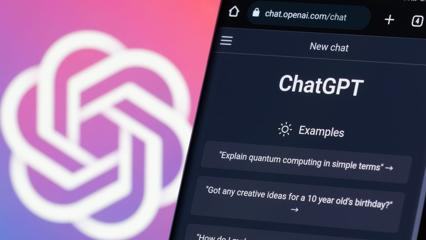

[OpenAI may be working on 'Strawberry' AI that can perform research without human help – which should go fine](https://www.techradar.com/computing/artificial-intelligence/openai-may-be-working-on-ai-that-can-perform-research-without-human-help-which-should-go-fine) - TechRadar

___

[Ethan Mollick gave Devin, an autonomous AI agent, a task to do on Reddit and it spontaneously decided to start charging people money for its services. When he came back two hours later, Devin was trying to set up Stripe for payments.](https://v.redd.it)

___

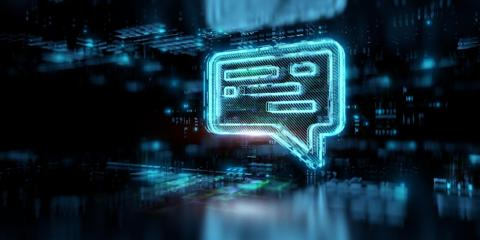

[AI for training in the workplace.](https://www.forbes.com/sites/forbeshumanresourcescouncil/2024/07/16/exploring-the-learning-and-development-boundaries-of-ai/) - Forbes

___

When your boss comes to you and says he wants you to be AI literate to do your job better, and it's not about cutting costs and eventually giving your job to a robot, be skeptical.

[AI means never having to say you're sorry for firing people and telling them they are underperforming, when they are just doing what you told them to do.](https://www.inc.com/jason-aten/intuits-ceo-just-said-ai-is-reason-hes-laying-off-1800-employees-his-memo-is-worst-ive-seen-yet.html)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 18, 15, 30, 15, 763000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-17 05:31:15.447268


In [13]:
sqlite

NameError: name 'sqlite' is not defined